In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RAINFALL
--------

Importing Libraries

In [48]:
# Data Analysis
import pandas as pd
import numpy as np
from pandas import to_datetime

# Data Visualization
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
#importing for arima
from statsmodels.tsa.arima.model import ARIMA
#importing for sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
#importing for prophet
from prophet import Prophet


# Machine Learning
from sklearn.metrics import mean_squared_error

Data Reading
-----------------------------

In [49]:
# Reading the file
df = pd.read_csv('/content/drive/MyDrive/Datasets/100_THESIS_FINAL/Rainfall/Faridpur.csv')
#the daily dataset
print(df.shape)
df.head()

(20188, 2)


,DATE,Rainfall(mm)
0,4/1/1961,0.0
1,4/2/1961,0.0
2,4/3/1961,0.0
3,4/4/1961,0.0
4,4/5/1961,0.0


In [50]:
#checking types
df.dtypes

DATE             object
Rainfall(mm)    float64
dtype: object

Data Preprocessing
---------

In [51]:
# 1. Checking missing values
df.isnull().sum()
# 2.Dropping nulls
print(df.dropna())

            DATE  Rainfall(mm)
0       4/1/1961           0.0
1       4/2/1961           0.0
2       4/3/1961           0.0
3       4/4/1961           0.0
4       4/5/1961           0.0
...          ...           ...
20183  4/26/2019           0.0
20184  4/27/2019           0.0
20185  4/28/2019           0.0
20186  4/29/2019           0.0
20187  4/30/2019           0.0

[20187 rows x 2 columns]


In [52]:
# 3.Check for duplicates
df.duplicated().sum()

0

In [53]:
df.head()

,DATE,Rainfall(mm)
0,4/1/1961,0.0
1,4/2/1961,0.0
2,4/3/1961,0.0
3,4/4/1961,0.0
4,4/5/1961,0.0


In [54]:
df.tail()

,DATE,Rainfall(mm)
20183,4/26/2019,0.0
20184,4/27/2019,0.0
20185,4/28/2019,0.0
20186,4/29/2019,0.0
20187,4/30/2019,0.0


In [55]:
# Preparing dataset for forecasting
df_pr = df
# 4.sorting dataset by date for forecast
df_pr.sort_values('DATE', inplace=True)
# 5.setting the index by date after sorting
df_pr.set_index('DATE', inplace=True)
df_pr.head()

,Rainfall(mm)
DATE,
1/1/1962,0.0
1/1/1964,0.0
1/1/1966,0.0
1/1/1967,0.0
1/1/1968,0.0


In [56]:
# 6.Resampling dataset to monthly timeseries
df_pr.index = pd.to_datetime(df_pr.index)
monthly = df_pr.resample('M').mean()
print(monthly.shape)
monthly.head()
monthly.to_csv("Faridpur_monthly.csv")

(697, 1)


In [57]:
# Understanding the data for TS
print(f'Start Date: {monthly.index.min()}')
print(f'End Date: {monthly.index.max()}')
print(f'Total month: {len(monthly)}')
print(f'Total year: {int(len(monthly.index)/12)}')

Start Date: 1961-04-30 00:00:00
End Date: 2019-04-30 00:00:00
Total month: 697
Total year: 58


Data Visulalization
----------

About Data

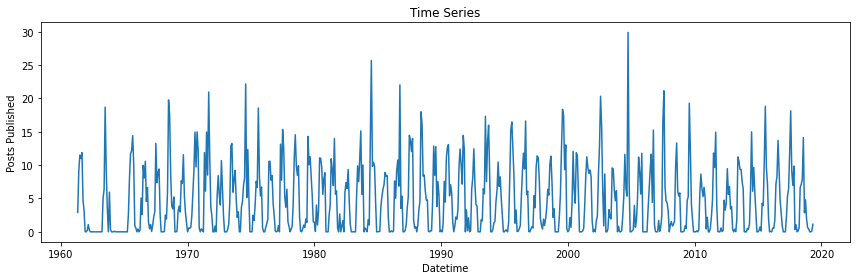

In [58]:
# 7.Plotting the time series
monthly['Rainfall(mm)'] = monthly['Rainfall(mm)'].fillna(0)
plt.figure(figsize=(12, 4))
plt.plot(monthly)
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Time Series')
plt.tight_layout()
plt.show()

Splitting the Train & Test data for forecasting

Shape: Train=(585, 1), Validation=(112, 1)


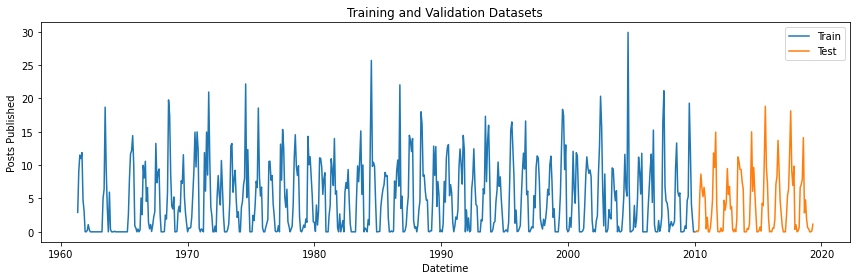

In [59]:
train = monthly.loc[:'2009-12-31']
valid = monthly.loc['2010-01-31':]
print(f'Shape: Train={train.shape}, Validation={valid.shape}')

# Plotting the training and validation datasets
plt.figure(figsize=(12, 4))
plt.plot(train, label='Train')
plt.plot(valid, label='Test')
plt.xlabel('Datetime')
plt.ylabel('Posts Published')
plt.title('Training and Validation Datasets')
plt.legend()
plt.tight_layout()
plt.show()

Indexing the train and test data into date form

In [60]:
train.index = pd.DatetimeIndex(train.index)
valid.index = pd.DatetimeIndex(valid.index)

In [61]:
# Visualizing the components of time series: Trend, Seasonality, and Noise
train.sort_index(inplace=True)
decomposition = sm.tsa.seasonal_decompose(train.dropna(), model = 'additive', period = int(len(train)/4))

Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category,trend, seasonality and noise.

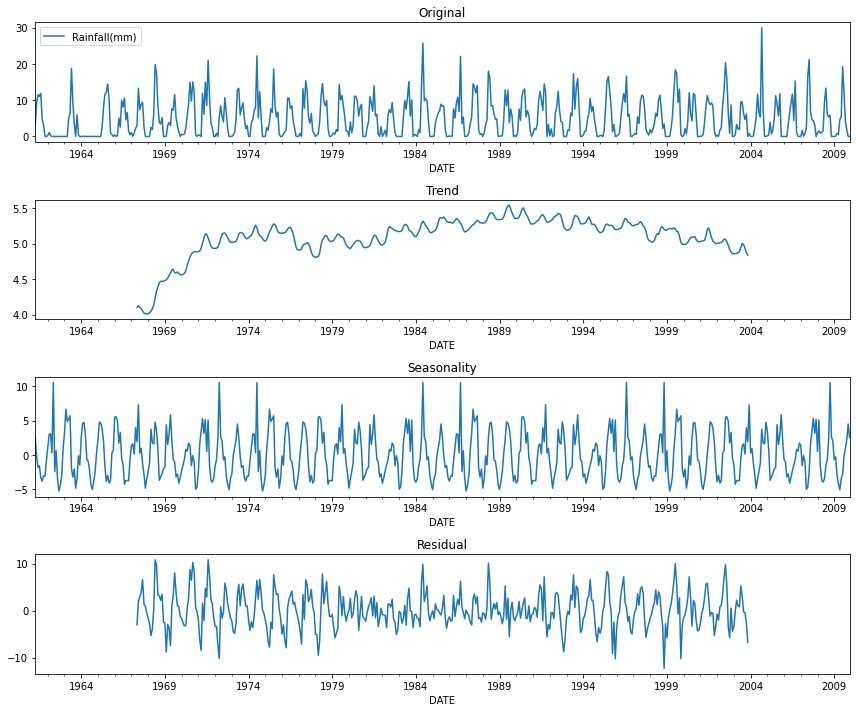

In [62]:
# Plotting the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10)) 
train.plot(title='Original', ax=axes[0])
decomposition.trend.plot(title='Trend', ax=axes[1])
decomposition.seasonal.plot(title='Seasonality', ax=axes[2])
decomposition.resid.plot(title='Residual', ax=axes[3])
plt.tight_layout()
plt.show()

In [63]:
# Creating a function to plot the results of the forecast
def plot_forecast(forecast, model, rmse):
    plt.figure(figsize=(12,4))
    plt.plot(train.dropna(), label='Training')
    plt.plot(valid.dropna(), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title(f'{model} (RMSE: {round(rmse, 2)})')
    plt.legend()
    plt.tight_layout()
    plt.show()

Checking Seasonality of TS DATA
------------

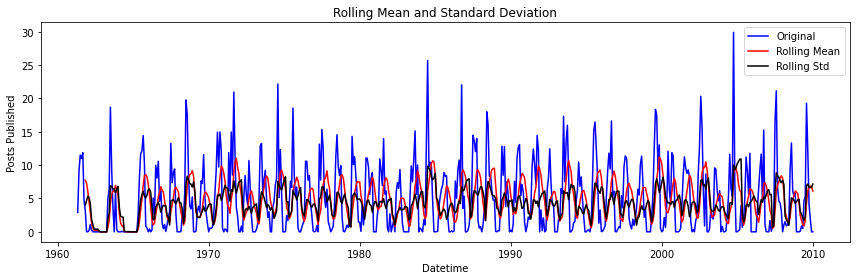

Results of Dickey-Fuller Test:
Test Statistic                -6.905094e+00
P-Value                        1.253164e-09
#Lags Used                     1.700000e+01
Number of Observations Used    5.670000e+02
Critical Value (1%)           -3.441936e+00
Critical Value (5%)           -2.866651e+00
Critical Value (10%)          -2.569492e+00
dtype: float64


In [64]:
# Creating a function to check stationarity of the train data
def check_stationarity(data):
    # Determining rolling statistics
    rol_mean = data.rolling(7).mean() #7 days in a week
    rol_std = data.rolling(7).std()
    
    # Plotting rolling statistics
    plt.figure(figsize=(12, 4))
    plt.plot(data, color='blue', label='Original')
    plt.plot(rol_mean, color='red', label='Rolling Mean')
    plt.plot(rol_std, color='black', label='Rolling Std')
    plt.xlabel('Datetime')
    plt.ylabel('Posts Published')
    plt.title('Rolling Mean and Standard Deviation')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Performing Dickey-Fuller test
    results = adfuller(data)
    df_output = pd.Series(results[:4], index=['Test Statistic', 'P-Value', '#Lags Used', 'Number of Observations Used'])
    for key, value in results[4].items():
        df_output[f'Critical Value ({key})'] = value
    print(f'Results of Dickey-Fuller Test:\n{df_output}')
    
# Stationarity check of our daily time series
check_stationarity(train)

###### As the test statistic is less than the critical values, we can say that the time series is already stationary. We can also see a trend in the visualization, therefore, we dont need to remove the trend and seasonality.

TIME SERIES MODELS
-----

ARIMA MODEL 

In [65]:
#MODEL implement and order set
arima = ARIMA(train, order=(7,1,1))

In [66]:
#model Fit
arima_model_fit = arima.fit()
# print summary of fit model
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Rainfall(mm)   No. Observations:                  585
Model:                 ARIMA(7, 1, 1)   Log Likelihood               -1586.138
Date:                Sun, 06 Nov 2022   AIC                           3190.275
Time:                        20:26:37   BIC                           3229.604
Sample:                    04-30-1961   HQIC                          3205.604
                         - 12-31-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3121      0.035      8.992      0.000       0.244       0.380
ar.L2          0.0390      0.038      1.019      0.308      -0.036       0.114
ar.L3         -0.0314      0.048     -0.660      0.5

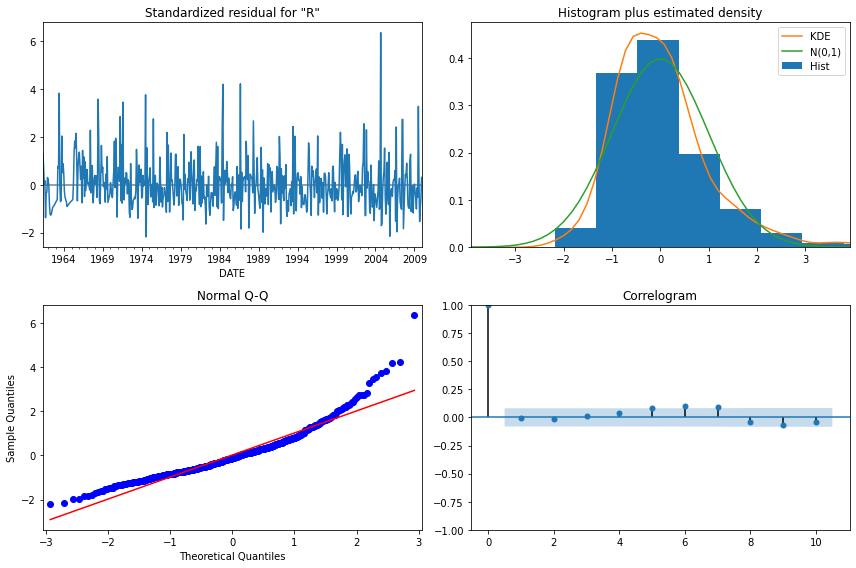

In [67]:
# Residual Plots
arima_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

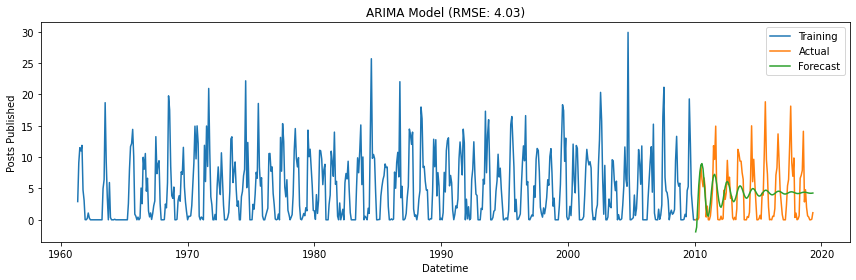

In [68]:
# Forecasting with the ARIMA model
forecast_arima = arima_model_fit.forecast(steps=len(valid))
arima_rmse = mean_squared_error(valid, forecast_arima, squared=False)
# # Plotting the ARIMA forecast
plot_forecast(forecast_arima, 'ARIMA Model', arima_rmse)

In [69]:
#Values of ARIMA prediction
print(forecast_arima)

2010-01-31   -1.920410
2010-02-28   -1.174914
2010-03-31    2.341873
2010-04-30    5.503361
2010-05-31    7.542982
                ...   
2018-12-31    4.271289
2019-01-31    4.243483
2019-02-28    4.234496
2019-03-31    4.245139
2019-04-30    4.271202
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [70]:
arima_rmse  = mean_squared_error(valid, forecast_arima,squared=False)
print('Arima Root Mean Squared Error: ',arima_rmse)

Arima Root Mean Squared Error:  4.025682689944353


---------------------

SARIMAX MODEL

In [71]:
#SARIMAX model order set
#(7,2,1, 12)
my_seasonal_order = (7,1,1, 12)
sarimax = SARIMAX(train, order=(7,1,1),seasonal_order=my_seasonal_order)

In [72]:
#Model fit
sarimax_model_fit = sarimax.fit()
# print summary of fit model
print(sarimax_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Rainfall(mm)   No. Observations:                  585
Model:             SARIMAX(7, 1, 1)x(7, 1, 1, 12)   Log Likelihood               -1508.696
Date:                            Sun, 06 Nov 2022   AIC                           3051.392
Time:                                    20:28:46   BIC                           3125.328
Sample:                                04-30-1961   HQIC                          3080.235
                                     - 12-31-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1511      0.037      4.056      0.000       0.078       0.224
ar.L2          0.0243      0.041   

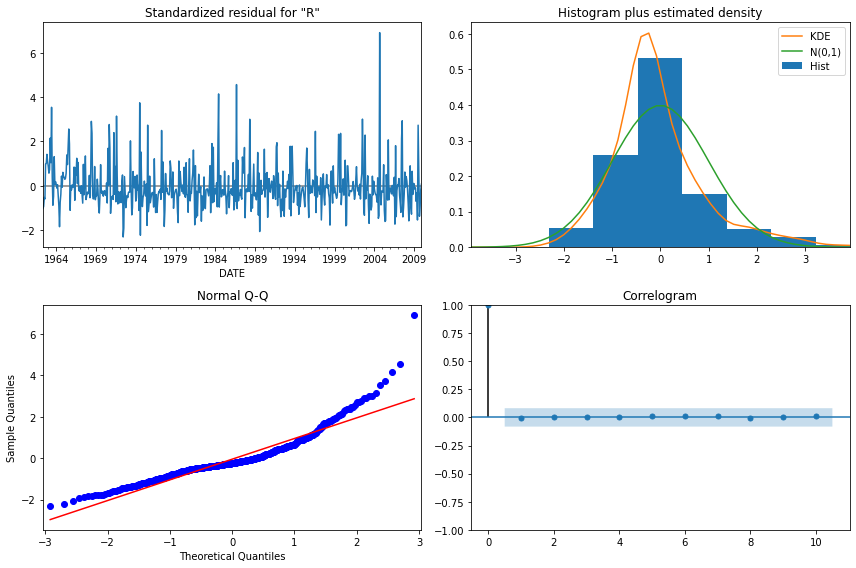

In [73]:
# Residual Plots
sarimax_model_fit.plot_diagnostics(figsize=(12,8))
plt.tight_layout()
plt.show()

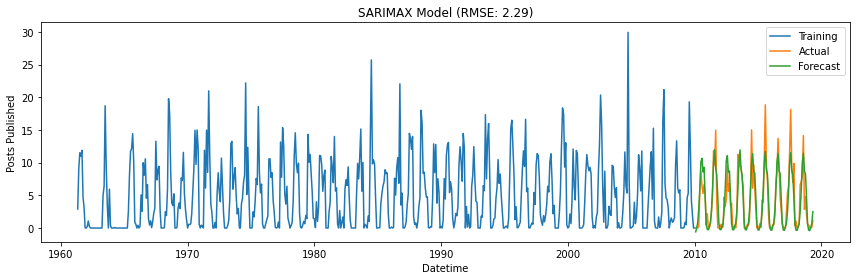

In [74]:
# Forecasting with the SARIMAX model
forecast_sarimax = sarimax_model_fit.forecast(steps=len(valid))
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
# # Plotting the SARIMAX forecast
plot_forecast(forecast_sarimax, 'SARIMAX Model', sarimax_rmse)

In [75]:
#Value of SARIMA prediction
print(forecast_sarimax)

2010-01-31   -0.581238
2010-02-28   -0.021359
2010-03-31    0.853157
2010-04-30    2.957453
2010-05-31    6.139120
                ...   
2018-12-31   -0.348919
2019-01-31   -0.383302
2019-02-28    0.123052
2019-03-31    0.688210
2019-04-30    2.503004
Freq: M, Name: predicted_mean, Length: 112, dtype: float64


In [76]:
sarimax_rmse = mean_squared_error(valid, forecast_sarimax, squared=False)
print('Sarimax Root Mean Squared Error: ',sarimax_rmse)

Sarimax Root Mean Squared Error:  2.288068912546254


-----------------------

PROPHET

In [77]:
#Reading monthly data 
df= pd.read_csv('Faridpur_monthly.csv')

In [78]:
#renaming column for formatting prophet
df.columns = ['ds','y']
df.head()

,ds,y
0,1961-04-30,2.910000
1,1961-05-31,9.100000
2,1961-06-30,11.510000
3,1961-07-31,10.996774
4,1961-08-31,11.880645


In [79]:
#prophet model Implement
prophet_model = Prophet()

In [80]:
#Model fit
fit=prophet_model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yw1wg99/boqadwk5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1yw1wg99/6vhg30ve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66658', 'data', 'file=/tmp/tmp1yw1wg99/boqadwk5.json', 'init=/tmp/tmp1yw1wg99/6vhg30ve.json', 'output', 'file=/tmp/tmp1yw1wg99/prophet_modellq28bwt9/prophet_model-20221106202847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [81]:
#forecasting the next 5 years monthly data
prophet_forecast_date = prophet_model.make_future_dataframe(periods=12 * 6, freq='M')
print(prophet_forecast_date)

            ds
0   1961-04-30
1   1961-05-31
2   1961-06-30
3   1961-07-31
4   1961-08-31
..         ...
764 2024-12-31
765 2025-01-31
766 2025-02-28
767 2025-03-31
768 2025-04-30

[769 rows x 1 columns]


In [82]:
#Prediting for the previous and next 5 years
prophet_prediction=prophet_model.predict(prophet_forecast_date)
prophet_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1961-04-30,4.962846,0.492506,7.303446,4.962846,4.962846,-1.176600,-1.176600,-1.176600,-1.176600,-1.176600,-1.176600,0.0,0.0,0.0,3.786246
1,1961-05-31,4.963646,3.996736,11.326271,4.963646,4.963646,2.612382,2.612382,2.612382,2.612382,2.612382,2.612382,0.0,0.0,0.0,7.576028
2,1961-06-30,4.964420,7.543760,14.599933,4.964420,4.964420,6.032409,6.032409,6.032409,6.032409,6.032409,6.032409,0.0,0.0,0.0,10.996829
3,1961-07-31,4.965221,7.358073,14.773058,4.965221,4.965221,6.210331,6.210331,6.210331,6.210331,6.210331,6.210331,0.0,0.0,0.0,11.175552
4,1961-08-31,4.966021,5.643343,13.157823,4.966021,4.966021,4.357265,4.357265,4.357265,4.357265,4.357265,4.357265,0.0,0.0,0.0,9.323285


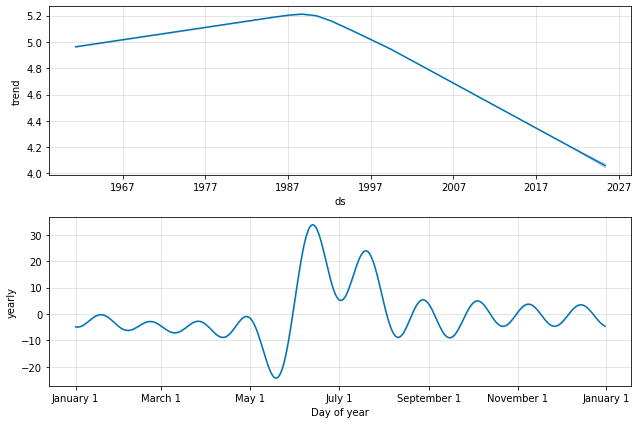

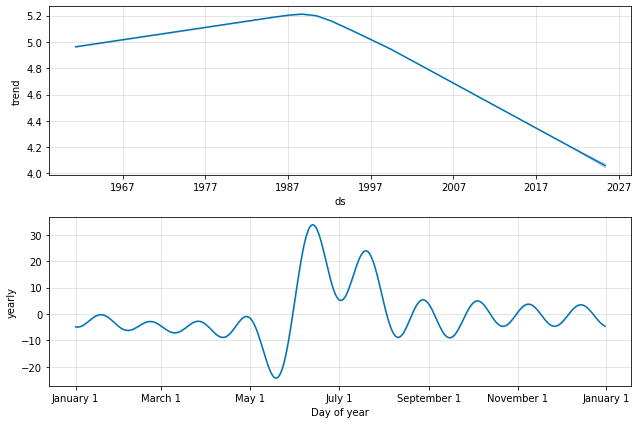

In [83]:
#### Visualize Each Components[Trends,yearly]
prophet_model.plot_components(prophet_prediction)

In [84]:
forecast_prophet_data=pd.DataFrame(prophet_prediction,columns=['ds','yhat'])
#setting the date as index of the dataframe 
fd=forecast_prophet_data.set_index('ds')
print(fd)

                 yhat
ds                   
1961-04-30   3.786246
1961-05-31   7.576028
1961-06-30  10.996829
1961-07-31  11.175552
1961-08-31   9.323285
...               ...
2024-12-31  -0.605846
2025-01-31  -0.827759
2025-02-28  -0.211018
2025-03-31   0.325901
2025-04-30   2.883582

[769 rows x 1 columns]


In [85]:
#converting the dataframe into series
full_forecast_prophet=fd['yhat'].squeeze()
print(full_forecast_prophet)

ds
1961-04-30     3.786246
1961-05-31     7.576028
1961-06-30    10.996829
1961-07-31    11.175552
1961-08-31     9.323285
                ...    
2024-12-31    -0.605846
2025-01-31    -0.827759
2025-02-28    -0.211018
2025-03-31     0.325901
2025-04-30     2.883582
Name: yhat, Length: 769, dtype: float64


In [86]:
forecast_prophet_valid=full_forecast_prophet['2010-01-31':'2019-04-30']

In [87]:
prophet_rmse = mean_squared_error(valid,forecast_prophet_valid, squared=False)
print('Prophet Root-mean-square error: ',prophet_rmse)

Prophet Root-mean-square error:  2.262337828904584


-----------------

MODEL Comparison
----------

Testing

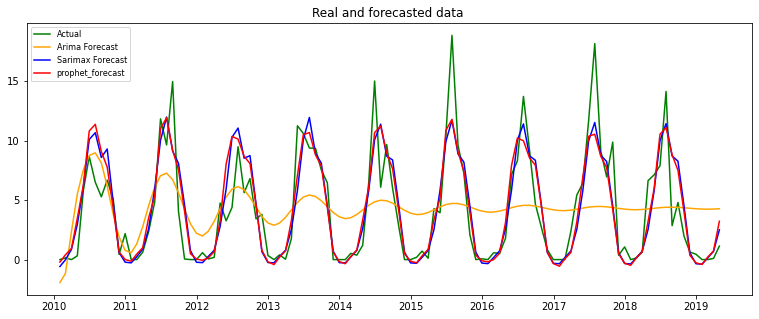

In [88]:
#comparing with test(actual) data
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("Real and forecasted data ")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_sarimax, label='Sarimax Forecast', color='blue')
plt.plot(forecast_prophet_valid, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Forecasting for 15 years since  2010 to 2025

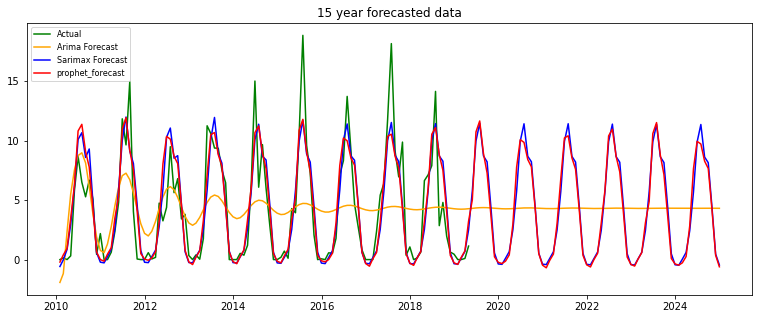

In [89]:
forecast_10_arima = arima_model_fit.forecast(steps=len(valid)+68)
forecast_10_sarima = sarimax_model_fit.forecast(steps=len(valid)+68)
forecast_10_prophet=full_forecast_prophet['2010-01-31':'2024-12-31']
plt.figure(figsize=(13, 5))
# plot Testing and Forecasted data
plt.title("15 year forecasted data")
plt.plot(valid, label='Actual', color='green')
plt.plot(forecast_10_arima, label='Arima Forecast', color='orange')
plt.plot(forecast_10_sarima, label='Sarimax Forecast', color='blue')
plt.plot(forecast_10_prophet, label='prophet_forecast', color='red')
plt.legend(loc='upper left', fontsize=8)
plt.show()

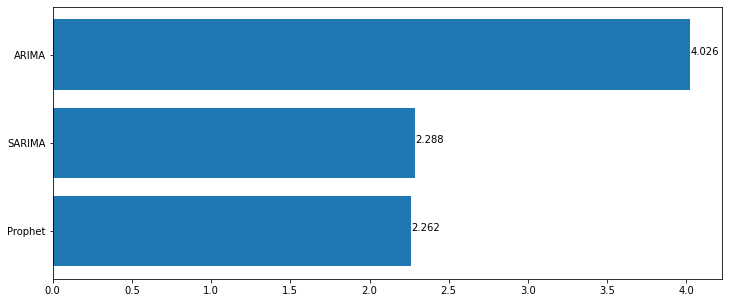

In [90]:
# Comparing Model Performances
plt.figure(figsize=(12, 5))
perf = pd.DataFrame({'Model': ['ARIMA', 'SARIMA', 'Prophet'],
                     'RMSE': [arima_rmse, sarimax_rmse, prophet_rmse]})
perf.sort_values('RMSE', inplace=True)
plt.barh(perf.Model, perf.RMSE)
 
for index,value in enumerate( perf.RMSE):
  final_value=round(value, 3)
  plt.text(value, index,str(final_value))
 
plt.show()

In [91]:
from datetime import date, datetime
print("--Enter the last date of the month between 2010 to 2024 to see the forecasted value--")
Date= (input('Enter a date in yyyy-mm-dd format :'))
print("")
if Date in forecast_10_arima.index or Date in forecast_10_sarima or Date in forecast_10_prophet:
  print("Great! Now choose the model result you want to see for",Date)
  model=int(input(' 1.Arima \n 2.Sarimax\n 3.Prophet\n '))
  if model==1:
    print("Choosen Model is Arima")
    print("In",Date,"rainfall value for Arima model: ",forecast_10_arima[Date])
  elif model==2:
    print("Choosen Model is Sarimax")
    print("In",Date,"rainfall value for Sarimax model: ",forecast_10_sarima[Date])
  elif model==3:
    print("Choosen Model is prophet")
    print("In",Date,"rainfall value for Prophet model: ",forecast_10_prophet[Date])
  else:
    print("choose among the three model")
else:
  print("Choose the correct date according to the mentioned format")


--Enter the last date of the month between 2010 to 2024 to see the forecasted value--
Enter a date in yyyy-mm-dd format :2012-12-31

Great! Now choose the model result you want to see for 2012-12-31
 1.Arima 
 2.Sarimax
 3.Prophet
 2
Choosen Model is Sarimax
In 2012-12-31 rainfall value for Sarimax model:  -0.24898426630335455


In [92]:
merged=pd.concat([forecast_10_arima,forecast_10_sarima,forecast_10_prophet])
merged.to_csv("Faridpur_monthly_merged.csv")